# TALLER 1 - Herramientas computacionales
### Diego Ulises Cruz Cruz
#### 201412142

#### Se importan las librerías a usar
▼

In [1]:
import os
import pandas as pd
from scipy import stats as st
%pylab inline

Populating the interactive namespace from numpy and matplotlib



#### Se crea la tabla comparativa que se va a usar al final del documento
▼

In [2]:
tabla=pd.DataFrame(columns=('CIUDAD','ENFICC','RMSNe %','MBE %',
                            'KSI %','AÑO INICIO','AÑO FIN','MES INICIO',
                            'MES FIN'))



#### Función que invoca la serie IDEAM o NREL para una ciudad

* Parametros: Nombre de la ciudad y tipo de serie (IDEAM o NREL)
* retorno: serie IDEAM o NREL para la ciudad deseada
▼

In [3]:
def ser_dat (ciudad,fuente):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
    serie_pd = pd.read_csv(serie_csv, sep = ';',encoding='latin-1')
    return serie_pd;


#### Función que entrega la energía total mensual en  $\frac{kWh}{m^{2}}$
* Parametros: Serie a la que se desea la energía total mensual
* Retorno: Una nueva serie, pero con los valores totales mensuales
▼


In [4]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df


#### Funcion que entrega la energía diaria mensual en $\frac{kWh}{m^{2}}$
* Parametros: Serie con valores totales mensuales
* Retorno: Una nueva serie, con valores totales diarios mensuales
▼

In [5]:
def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df


#### Función que calcula el valor promedio mensual para la serie deseada
* Parametro: Serie que se desea calcular el valor promedio mensual
* retorno: serie con los valores promedios mensuales
▼

In [6]:
def val_prom_mes (serie_Horaria):
    
    ghi_mes= ghi_mensual(serie_Horaria)
    ghi_diario= ghi_dia(ghi_mes)
    datos = sorted(ghi_diario["GHIdiario"])
    return datos


#### Función grafica dos series según los ejes de Energía/Energía Base IDEAM vs Datos
* Parametros:Serie que se desea tener el valor de energía, Serie IDEAM y Nombre que se desea poner a la gráfica
* retorno: Gráfica de Energía/Energía Base IDEAM vs Datos
▼

In [7]:
def graph(serie,data_IDEAM,nombre):
    
    dat_ser=val_prom_mes(serie)
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    numdatos = range(len(dat_ser))
    pylab.plot(numdatos,dat_ser/data_IDEAM[0], label=nombre);
    pylab.legend(loc='upper left');
    return pylab.plot


#### Funcion que calcula la ENFICC en el percentil 99%
* Parametros:Serie que se desea tener el valor de la ENFICC
* retorno: ENFICC
▼

In [8]:
def percen(serie_Horaria):
    prom_mes=val_prom_mes(serie_Horaria)
    percentil = 1
    arra=np.asarray(prom_mes)
    enficc = np.percentile(arra,percentil)
    return enficc


#### Funcion que calcula la media y desviación estandar
* Parametros:Serie a la que se desea tener el valor de la media y desviación estandar
* retorno: media y desviación estandar
▼

In [9]:
def med_desvEst(serie):
    media=np.mean(serie)
    desvesta=np.std(serie)
    return media,desvesta


#### Funcion que recorta una serie en un periodo de tiempo
* Parametros: Serie a recortar, año de inicio, año de finalización, mes de inicio en el año de inicio, mes de finalización en el año de finalización
* retorno: serie recortada
▼

In [10]:
def recortes(serie, agno_ini, agno_fin, mes_ini, mes_fin):
    if (agno_ini!=agno_fin) & (agno_fin-agno_ini>=2):
        ser_1=serie[(serie['AÑO']==agno_ini)&(serie['MES']>=mes_ini)]
        ser_2=serie[(serie['AÑO']>agno_ini)&(serie['AÑO']<agno_fin)]
        ser_3=serie[(serie['AÑO']==agno_fin)&(serie['MES']<=mes_fin)]
        frame=[ser_1,ser_2,ser_3]
        ser=pd.concat(frame)
        
    if (agno_ini!=agno_fin) & (agno_fin-agno_ini<2):
        ser_1=serie[(serie['AÑO']==agno_ini)&(serie['MES']>=mes_ini)]
        ser_2=serie[(serie['AÑO']==agno_fin)&(serie['MES']<=mes_fin)]
        frame=[ser_1,ser_2]
        ser=pd.concat(frame)
    if (agno_ini==agno_fin):
        ser=serie[(serie['AÑO']==agno_ini)&(serie['MES']>=mes_ini)&
                  (serie['MES']<=mes_fin)]
    
    return ser
    


#### Funcion que calcula el mcp
* Parametros: Serie de guía corta, serie NREL a corregir y serie guia
* retorno: MCP
▼

In [11]:
def mcp(IDEAM_GUIA,NREL,NREL_GUIA):
    mu_x, desvesta_x=med_desvEst(NREL_GUIA)
    mu_y, desvesta_y=med_desvEst(IDEAM_GUIA)
    
    return ((mu_y-(desvesta_y/desvesta_x)*mu_x)+(desvesta_y/desvesta_x)*NREL)


#### Funcion que corrige la serie
* Parametros: Ciudad, año de inicio, año de finalización, mes de inicio, y mes de finalización
* retorno: Función corregida
▼

In [12]:
def ser_correg(ciudad,agno_ini, agno_fin, mes_ini, mes_fin):
    IDEAM=ser_dat(ciudad,'IDEAM')
    prom_mes=val_prom_mes(IDEAM)
    NREL=ser_dat(ciudad,'NREL')
    ser_guia=recortes(IDEAM,agno_ini, agno_fin, mes_ini, mes_fin) ['IDEAM']
    nrel_guia=recortes(NREL,agno_ini, agno_fin, mes_ini, mes_fin) ['NREL']
    fun_corr_1=mcp(ser_guia,NREL['NREL'],nrel_guia)
    fun_corr=NREL
    fun_corr['NREL']=fun_corr_1
    fun_corr=fun_corr.clip(lower=0)
    
    return fun_corr


#### Funcion que plotea la serie IDEAM, NREL y la corregida para una función
* Parametros: Ciudad, año de inicio, año de finalización, mes de inicio, y mes de finalización
* retorno: Plot de la gráfica
▼

In [13]:
def city(ciudad,agno_ini, agno_fin, mes_ini, mes_fin):
    output_dir = os.path.join( '.','output')
    ser_ideam=ser_dat(ciudad,'IDEAM')
    ser_nrel=ser_dat(ciudad,'NREL')
    prom=val_prom_mes(ser_ideam)
    graph(ser_ideam,prom,'IDEAM')
    graph(ser_nrel,prom,'NREL')
    fun_corr=ser_correg(ciudad,agno_ini, agno_fin, mes_ini, mes_fin)
    graph(fun_corr,prom,'CORREGIDA')
    pylab.savefig(os.path.join(output_dir,ciudad+'.png'), dpi=600)


#### Funcion que calcula el error RMS (RMSEn)
* Parametros: Serie observada, y serie Corregida
* retorno: error RMSEn
▼

In [14]:
def RMSEn(ser_obser,ser_modif):
    n=len(ser_modif)
    ser_obs=np.array(ser_obser['IDEAM'])
    ser_mod=np.array(ser_modif['NREL'])
    sumatoria=(np.sum((ser_obs-ser_mod)**2))
    x_obs_max=np.max(ser_obs)
    x_obs_min=np.min(ser_obs)
    rmsen=(np.sqrt((1/n)*sumatoria))/(x_obs_max-x_obs_min)
    return rmsen


#### Funcion que calcula el error de sesgo medio (MBE)
* Parametros: Serie observada, y serie Corregida
* retorno: error de sesgo medio
▼

In [15]:
def MBE(ser_obser,ser_modif):
    ser_obs=np.array(ser_obser['IDEAM'])
    ser_mod=np.array(ser_modif['NREL'])
    sumatoria=(np.sum(ser_mod-ser_obs))
    sum_x_obs=(np.sum(ser_obs))
    mbe=sumatoria/sum_x_obs
    return mbe


#### Funcion que calcula el índice de Kolmogorov-Smagorinski 
* Parametros: Serie observada, y serie Corregida
* retorno: KSI
▼

In [16]:
def KSI(ser_obs,ser_mod):
       
    ser_obser=np.array(ser_obs['IDEAM'])
    ser_modif=np.array(ser_mod['NREL'])
    ksi_1=st.ks_2samp(ser_obser,ser_modif)
    ksi=np.array(ksi_1)
    return ksi[0]


#### Funcion que utiliza las funciones anteriores para generar una gráfica y calcular los errores de una serie corregida por un periodo de tiempo
* Parametros: Ciudad, año de inicio, año de finalización, mes de inicio, y mes de finalización
* retorno: Grafica, ENFICC de la serie NREL, ENFICC de la serie corregida y Errores de la serie corregida
▼

In [17]:
def estimacion(ciudad,agno_ini, agno_fin, mes_ini, mes_fin):
    ser_sat=ser_dat(ciudad,'NREL')
    print ('La ENFICC 99% es de:',percen(ser_sat),'en la ciudad de:',
           ciudad,'antes de realizar la corrección')
    city(ciudad,agno_ini, agno_fin, mes_ini, mes_fin)
    ser_mod=ser_correg(ciudad,agno_ini, agno_fin, mes_ini, mes_fin)
    
    
    ser_obser=ser_dat(ciudad,'IDEAM')
    
    ser_max=np.max(np.array(ser_obser['AÑO']))
    ser_min=np.min(np.array(ser_obser['AÑO']))
    
    ser_modif=recortes(ser_mod, ser_min, ser_max, 1, 12)
    
    print ('La ENFICC 99% de la serie corregida es:',percen(ser_mod),
           'en la ciudad de:',ciudad)
    
    print ('RMSEn es:',RMSEn(ser_obser,ser_modif)*100,'%',
           ', MBE es:',MBE(ser_obser,ser_modif)*100,'%', 
           'y KSI es:', KSI(ser_obser,ser_modif)*100,'%')


#### Funcion que utiliza la tabla anteriormente creada, y añade el RMSEn, MBE, KSI y el periodo de tiempo con el cual se calculó estos valores
* Parametros: Ciudad, año de inicio, año de finalización, mes de inicio, y mes de finalización
* retorno: Tabla con la ciudad y distintos parámetros del error de la serie corregida
▼

In [18]:
def table(ciudad,agno_ini, agno_fin, mes_ini, mes_fin):
   
    ser_mod=ser_correg(ciudad,agno_ini, agno_fin, mes_ini, mes_fin)
    ser_obser=ser_dat(ciudad,'IDEAM')
    ser_max=np.max(np.array(ser_obser['AÑO']))
    ser_min=np.min(np.array(ser_obser['AÑO']))
    
    ser_modif=recortes(ser_mod, ser_min, ser_max, 1, 12)
    
    df=pd.DataFrame([[ciudad,percen(ser_mod),RMSEn(ser_obser,ser_modif)*100,
                     MBE(ser_obser,ser_modif)*100,
                     KSI(ser_obser,ser_modif)*100,agno_ini, agno_fin, mes_ini,
                     mes_fin]],columns=('CIUDAD','ENFICC','RMSNe %','MBE %',
                     'KSI %','AÑO INICIO','AÑO FIN','MES INICIO','MES FIN'))
    global tabla
    tabla=tabla.append(df)
    return tabla


#### Implementación de las funciones previamente definidas para cada una de las ciudades
### Barranquilla

La ENFICC 99% es de: 4.60594683333 en la ciudad de: Barranquilla antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.64694048266 en la ciudad de: Barranquilla
RMSEn es: 10.8055186766 % , MBE es: 4.88930404576 % y KSI es: 3.0750798722 %


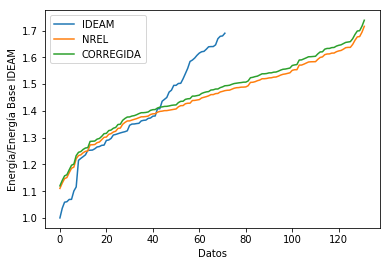

In [19]:
estimacion('Barranquilla',2010, 2012, 10, 2)

Como se puede apreciar, La ENFICC se modificó comparando antes y despues de la correción, en el caso de la ciudad de Barranquilla, la ENFICC se incrementó, ya que NREL estimó por debajo a lo real de la ciudad.

### Cali

La ENFICC 99% es de: 4.36085916667 en la ciudad de: Cali antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 3.74548387046 en la ciudad de: Cali
RMSEn es: 10.2664468898 % , MBE es: 2.76062724082 % y KSI es: 4.0259608559 %


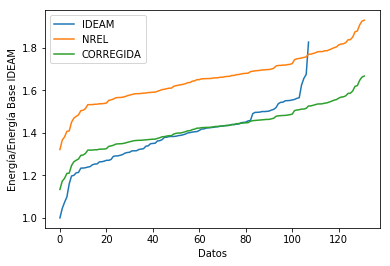

In [20]:
estimacion('Cali',2007, 2009, 10, 2)

En el caso de la ciudad de Cali, la ENFICC disminuyó, esto quiere decir que el NREL estaba sobreestimando los valores de la energía.

### Carmen de Bolívar

La ENFICC 99% es de: 4.2736665 en la ciudad de: Carmendebolivar antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.61622201494 en la ciudad de: Carmendebolivar
RMSEn es: 10.9257975437 % , MBE es: 12.2269116662 % y KSI es: 4.79540614542 %


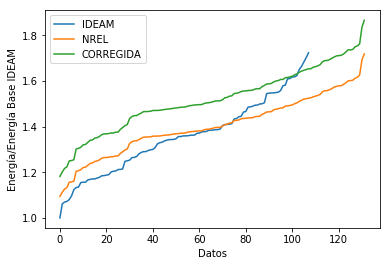

In [21]:
estimacion('Carmendebolivar',2007, 2009, 10, 2)

Como se puede apreciar en la gráfica anterior, en el Carmen de Bolivar, la corregida subió la energía de la ENFICC.


#### Los comentarios de las siguientes gráficas se omiten ya que es lo mismo de las anteriores, al final hay más explicación en conjunto a la tabla

### Medellín

La ENFICC 99% es de: 4.32600282796 en la ciudad de: Medellin antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 3.70865883889 en la ciudad de: Medellin
RMSEn es: 10.1084254544 % , MBE es: 2.97496533738 % y KSI es: 2.94701533406 %


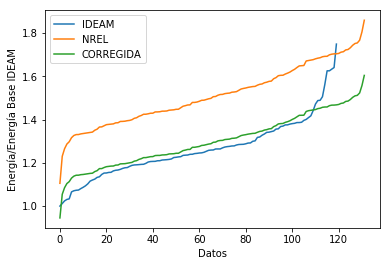

In [22]:
estimacion('Medellin',2007, 2009, 10, 2)


### Santa Marta

La ENFICC 99% es de: 4.536077 en la ciudad de: SantaMarta antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.18407376566 en la ciudad de: SantaMarta
RMSEn es: 8.2471738878 % , MBE es: -3.79803509735 % y KSI es: 2.95317134383 %


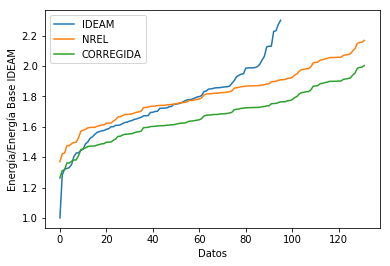

In [23]:
estimacion('SantaMarta',2008, 2010, 10, 2)


### Sucre

La ENFICC 99% es de: 4.8399985 en la ciudad de: Sucre antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.38745331611 en la ciudad de: Sucre
RMSEn es: 10.8717987762 % , MBE es: 6.49314835857 % y KSI es: 3.74794633078 %


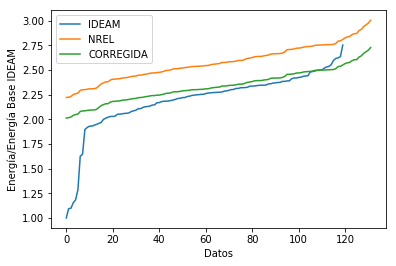

In [24]:
estimacion('Sucre',2007, 2009, 10, 2)


### Uribia

La ENFICC 99% es de: 4.62250183333 en la ciudad de: Uribia antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.337570086 en la ciudad de: Uribia
RMSEn es: 11.1784031681 % , MBE es: 1.96163971535 % y KSI es: 2.13809784593 %


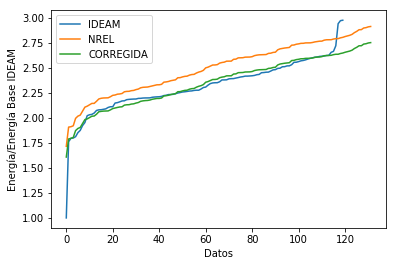

In [25]:
estimacion('Uribia',2007, 2009, 10, 2)


### Valledupar

La ENFICC 99% es de: 5.06265316667 en la ciudad de: Valledupar antes de realizar la corrección
La ENFICC 99% de la serie corregida es: 4.68163494087 en la ciudad de: Valledupar
RMSEn es: 8.41038536235 % , MBE es: 3.25607114197 % y KSI es: 2.11527929901 %


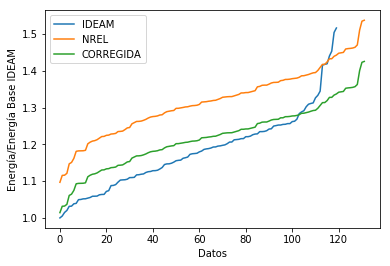

In [26]:
estimacion('Valledupar',2007, 2009, 10, 2)


#### Esta es la implementación de la tabla, en la cual para cada ciudad se tomó un periodo con el fenómeno de la niña, 3 periodos de la misma longitud pero distinto inicio, y 3 periodos con mismo inicio, pero distinta longitud

In [27]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Barranquilla',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Barranquilla',2012, 2013, 3, 10);
table('Barranquilla',2011, 2012, 3, 10);
table('Barranquilla',2013, 2014, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Barranquilla',2011, 2012, 4, 10);
table('Barranquilla',2011, 2013, 4, 10);
table('Barranquilla',2011, 2014, 4, 10);

In [28]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Cali',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Cali',2007, 2008, 3, 10);
table('Cali',2008, 2009, 3, 10);
table('Cali',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Cali',2007, 2008, 4, 10);
table('Cali',2007, 2009, 4, 10);
table('Cali',2007, 2010, 4, 10);

In [29]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Carmendebolivar',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Carmendebolivar',2007, 2008, 3, 10);
table('Carmendebolivar',2008, 2009, 3, 10);
table('Carmendebolivar',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Carmendebolivar',2007, 2008, 4, 10);
table('Carmendebolivar',2007, 2009, 4, 10);
table('Carmendebolivar',2007, 2010, 4, 10);

In [30]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Medellin',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Medellin',2007, 2008, 3, 10);
table('Medellin',2008, 2009, 3, 10);
table('Medellin',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Medellin',2007, 2008, 4, 10);
table('Medellin',2007, 2009, 4, 10);
table('Medellin',2007, 2010, 4, 10);

In [31]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('SantaMarta',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('SantaMarta',2008, 2009, 3, 10);
table('SantaMarta',2009, 2010, 3, 10);
table('SantaMarta',2011, 2012, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('SantaMarta',2008, 2009, 4, 10);
table('SantaMarta',2008, 2010, 4, 10);
table('SantaMarta',2008, 2011, 4, 10);

In [32]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Sucre',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Sucre',2007, 2008, 3, 10);
table('Sucre',2008, 2009, 3, 10);
table('Sucre',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Sucre',2007, 2008, 4, 10);
table('Sucre',2007, 2009, 4, 10);
table('Sucre',2007, 2010, 4, 10);

In [33]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Uribia',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Uribia',2007, 2008, 3, 10);
table('Uribia',2008, 2009, 3, 10);
table('Uribia',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Uribia',2007, 2008, 4, 10);
table('Uribia',2007, 2009, 4, 10);
table('Uribia',2007, 2010, 4, 10);

In [34]:
#Entre el año 2010 y 2011 ocurrió un fenomeno de la niña
table('Valledupar',2010, 2011, 10, 3);

#se escogió distintos años para empezar, pero con la misma longitud
table('Valledupar',2007, 2008, 3, 10);
table('Valledupar',2008, 2009, 3, 10);
table('Valledupar',2009, 2010, 3, 10);

#Las últimas 3 iteraciones empezaban desde el mismo año, pero teniendo una
#longitud distinta
table('Valledupar',2007, 2008, 4, 10);
table('Valledupar',2007, 2009, 4, 10);
table('Valledupar',2007, 2010, 4, 10)

,CIUDAD,ENFICC,RMSNe %,MBE %,KSI %,AÑO INICIO,AÑO FIN,MES INICIO,MES FIN
0,Barranquilla,4.748758,10.982540,7.133771,3.727370,2010,2011,10,3
0,Barranquilla,4.426101,10.525487,-0.053670,2.375247,2012,2013,3,10
0,Barranquilla,4.474499,10.572703,1.034900,2.375247,2011,2012,3,10
0,Barranquilla,4.267475,10.463880,-3.387316,3.444013,2013,2014,3,10
0,Barranquilla,4.455734,10.556129,0.627638,2.375247,2011,2012,4,10
0,Barranquilla,4.481625,10.579275,1.189438,2.375247,2011,2013,4,10
0,Barranquilla,4.400259,10.525404,-0.510085,2.612962,2011,2014,4,10
0,Cali,3.585291,10.096781,-1.551831,4.378359,2010,2011,10,3
0,Cali,3.724591,10.240464,2.213255,4.146385,2007,2008,3,10
0,Cali,3.741649,10.257338,2.642923,4.022158,2008,2009,3,10


* Como se puede apreciar en la tabla anterior, ningún error RMSNe es menor al 10%, y este no necesariamente decrece con una menor cantidad de datos, esto se debe a que es mejor escoger un buen año, que un lapso muy grande de tiempo.
* El MBE no importa si es negativo o positivo, ya que este indica que tan sesgada o insesgada es la aproximación que se hizo
* El KSI se mantuvo mas o menos constante, solo hubo dos casos excepcionales en la ciudad de Medellín y en el Carmen de Bolívar en el periodo que hubo un fenomeno de La Niña, lo cual nos indica que la predicción realizada en ese lapso de tiempo no es buena, ya que la alta nubosidad no afecta positivamente los valores de energía.
